<img src="../../img/land_use_clc.png" alt="" style="width: 100%; border-radius: 20px;"/>

## Objective
ToDo:

why did we create this notebook? why landuse?

## Scope

In this file we process a bird dataframe and merge it with the Corine Land Cover Dataframe to get the land use on the location of a bird sighting. With the functions given in this file it is possible to get the land use on the coordinate, to get the most common land use in a square or to get all land uses per percentage in a square around the coordinate.

The CLC was used because the LUCAS dataframe was used first and gave a much less detailed result. The LUCAS dataframe has points on a map which describe the land use whereas the CLC dataframe has polygons all over the map.

To get the land use with LUCAS the nearest point to the coordinate has to be selected. To do the same with CLC (altough much more precises) the coordinates of the bird dataframe are checked whether they are in any polygon. Then the land use of this polygon is used.

To get the most common land use within a square we create squares around each coordinate. Then each square is checked for the landuses within. Then the most common land uses gets returned.

The probably best solution to get the land use is to get the percentage of landuses in each square. This can be done by checking how much of each polygon is in each square. This is really compute heavy and this is also why there might be a better option:

To accomplish this another aspect of the CLC data is used. The CLC data also has points all over the map which can be used to get the land use. While those points also could be inaccurate if looking for the land use on a coordinate, those specific points inside of the square could be counted and calculated how much of each land use is in each square.

In [1]:
import geopandas as gpd
from shapely.geometry import Point, box
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
df_path = r'D:\\Simon\\Documents\\GP\\data\\master_train.csv'
df = pd.read_csv(df_path, index_col=0, low_memory=False)

In [63]:
df.tail(2)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id
2660041,15002282,8,Haubentaucher,2018-02-17,47.512154,9.436332,390,1,0,ch,50kmE4250N2700
2660042,15002291,8,Haubentaucher,2018-02-17,47.121205,7.240961,430,1,0,ch,50kmE4100N2650


In [5]:
df.drop(columns=['unclassified_area_percent', 'urban_area_percent','industrial_area_percent','agriculture_area_percent','forest_area_percent','grassland_area_percent','shrubland_area_percent','coastal_area_percent','rocky_area_percent','sparsley_vegetated_area_percent','burnt_area_percent','glacier_area_percent','wetlands_area_percent','water_area_percent'], inplace=True)

In [6]:
clc_path = r'D:\\Simon\\Documents\\GP\\data\\util_files\\CLC_2018_EU_Crop\\U2018_CLC2018_V2020_20u1_crop.gpkg'
clc = gpd.read_file(clc_path)

In [7]:
clc['Code_18'].fillna(999, inplace=True)
clc['Code_18'] = clc['Code_18'].astype(int)
clc.drop(columns=['Remark','Area_Ha','ID', 'OBJECTID'], axis=1, inplace=True)

In [9]:
clc.head(2)

,Code_18,geometry
0,112,"MULTIPOLYGON (((3852601.053 2979540.102, 38526..."
1,112,"MULTIPOLYGON (((3851007.206 2981146.329, 38510..."


In [10]:
clc.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

In [11]:
clc_4326 = clc.to_crs("EPSG:4326")

In [12]:
clc_4326.head(2)

,Code_18,geometry
0,112,"MULTIPOLYGON (((3.49281 49.74160, 3.49325 49.7..."
1,112,"MULTIPOLYGON (((3.46882 49.75471, 3.46911 49.7..."


## Get landuse on coordinate

In [13]:
df.drop(columns=['land_use_coord', 'land_use_coord_numeric'], inplace=True)

In [117]:
df.tail(2)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent
2660041,15002282,8,Haubentaucher,2018-02-17,47.512154,9.436332,390,1,0,ch,50kmE4250N2700,0.519785,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480215,0.0
2660042,15002291,8,Haubentaucher,2018-02-17,47.121205,7.240961,430,1,0,ch,50kmE4100N2650,0.837752,0.0,0.060568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101679,0.0


In [118]:
geometry = [Point(lon, lat) for lon, lat in zip(df['coord_lon'], df['coord_lat'])]
# gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3035")
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

merged_gdf = gpd.sjoin(gdf, clc_4326, how="left", predicate="within")

merged_gdf.drop(columns=['geometry','index_right'], axis=1, inplace=True)

In [119]:
merged_gdf.tail(5)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,Code_18
2660038,27523548,469,Bergpieper,2022-08-01,46.563896,8.551648,2085,4,0,ch,50kmE4200N2600,0.000000,0.0,0.000000,0.000000,0.580765,0.0,0.0,0.261244,0.005815,0.0,0.0,0.0,0.152176,0.0,321.0
2660039,27523686,338,Mittelspecht,2022-10-08,47.383318,7.666533,798,1,0,ch,50kmE4100N2650,0.000000,0.0,0.695808,0.304192,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,242.0
2660040,15002272,123,Bergente,2018-02-17,47.512154,9.436332,390,1,0,ch,50kmE4250N2700,0.519785,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.480215,0.0,512.0
2660041,15002282,8,Haubentaucher,2018-02-17,47.512154,9.436332,390,1,0,ch,50kmE4250N2700,0.519785,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.480215,0.0,512.0
2660042,15002291,8,Haubentaucher,2018-02-17,47.121205,7.240961,430,1,0,ch,50kmE4100N2650,0.837752,0.0,0.060568,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.101679,0.0,112.0


In [120]:
nan_rows = merged_gdf[merged_gdf['Code_18'].isna()]
len(nan_rows)

46

In [121]:
nan_rows.head(5)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,Code_18
155188,38355619,463,Wiesenpieper,2019-04-03,54.033346,6.626898,0,2,NaN,de,50kmE4100N3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
257889,34581793,463,Wiesenpieper,2018-09-04,54.494140,7.874070,0,0,NaN,de,50kmE4150N3450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
257890,34581823,399,Steinschmätzer,2018-09-04,54.052516,6.640945,0,1,NaN,de,50kmE4100N3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
286363,31552365,531,Rohrammer,2018-04-05,55.087171,6.038972,-1,0,NaN,de,50kmE4050N3550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
324169,34581853,399,Steinschmätzer,2018-09-05,54.052516,6.640945,0,0,NaN,de,50kmE4100N3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [122]:
layout = go.Layout(mapbox=dict(style='open-street-map', zoom=10), showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
fig = go.Figure(layout=layout)

def add_trace(row):
    bird_sighting = row.copy()
    bird_sighting['color'] = '#d00000'
    geometry = gpd.points_from_xy([bird_sighting['coord_lon']], [bird_sighting['coord_lat']])
    gdf_data_point = gpd.GeoDataFrame([bird_sighting], geometry=geometry, crs='EPSG:4326')

    fig.add_trace(px.scatter_mapbox(gdf_data_point,
                    lat='coord_lat', lon='coord_lon', size_max=10, color_discrete_sequence=[gdf_data_point.color],
                    hover_name=gdf_data_point['name_species']).data[0]) 

nan_rows.apply(add_trace, axis=1)

fig.update_layout(mapbox_style='open-street-map', mapbox_zoom=5, mapbox_center={'lat': 55, 'lon': 10})
fig.show()


In [123]:
nan_rows.head(5)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,Code_18
155188,38355619,463,Wiesenpieper,2019-04-03,54.033346,6.626898,0,2,NaN,de,50kmE4100N3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
257889,34581793,463,Wiesenpieper,2018-09-04,54.494140,7.874070,0,0,NaN,de,50kmE4150N3450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
257890,34581823,399,Steinschmätzer,2018-09-04,54.052516,6.640945,0,1,NaN,de,50kmE4100N3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
286363,31552365,531,Rohrammer,2018-04-05,55.087171,6.038972,-1,0,NaN,de,50kmE4050N3550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
324169,34581853,399,Steinschmätzer,2018-09-05,54.052516,6.640945,0,0,NaN,de,50kmE4100N3400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [124]:
merged_gdf['Code_18'].fillna(999, inplace=True)

In [125]:
clc_code_to_landuse = {
    111: 'urban', # 1
    112: 'urban',
    121: 'urban',
    122: 'urban',
    123: 'urban',
    124: 'urban',
    131: 'industrial', # 2
    132: 'industrial',
    133: 'industrial',
    141: 'urban', 
    142: 'urban',
    211: 'agriculture', # 3
    212: 'agriculture',
    213: 'agriculture',
    221: 'agriculture',
    222: 'agriculture',
    223: 'agriculture',
    231: 'agriculture',
    241: 'agriculture',
    242: 'agriculture',
    243: 'agriculture',
    244: 'agriculture',
    311: 'forest', # 4
    312: 'forest',
    313: 'forest',
    321: 'grassland', # 5 
    322: 'grassland',
    323: 'mediterranean_vegetation', # 6 
    324: 'shrubland', # 7 
    331: 'coastal', # 8 
    332: 'rocky_area',# 9
    333: 'sparsley_vegetated', # 10
    334: 'burnt_area', # 11
    335: 'glacier', # 12
    411: 'wetlands', # 13
    412: 'wetlands',
    421: 'wetlands',
    422: 'wetlands',
    423: 'wetlands',
    511: 'water', # 14
    512: 'water',
    521: 'water',
    522: 'water',
    523: 'water',
    990: 'unclassified_land', # 15
    995: 'unclassified_water', # 16
    999: 'unclassified' # 17
}
merged_gdf['land_use_coord'] = merged_gdf['Code_18'].map(clc_code_to_landuse)
merged_gdf.drop(columns=['Code_18'], axis=1, inplace=True)

In [126]:
merged_gdf.head(5)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,land_use_coord
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,0.191298,0.000000,0.399560,0.000000,0.0,0.021766,0.0,0.0,0.0,0.0,0.0,0.0,0.387377,0.0,water
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,agriculture
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,0.405476,0.000000,0.594524,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,urban
3,29666414,8,Haubentaucher,2018-01-01,51.076006,11.038316,157,8,NaN,de,50kmE4350N3100,0.000000,0.004445,0.376111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.619445,0.0,water
4,29656211,8,Haubentaucher,2018-01-01,51.389380,7.067282,52,10,NaN,de,50kmE4100N3100,0.362214,0.000000,0.024020,0.211704,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.402062,0.0,urban


In [127]:
landuse_to_numerical = {
    'urban': 1,
    'industrial': 2,
    'agriculture': 3,
    'forest': 4,
    'grassland': 5,
    'mediterranean_vegetation': 6,
    'shrubland': 7,
    'coastal': 8,
    'rocky_area': 9,
    'sparsley_vegetated': 10,
    'burnt_area': 11,
    'glacier': 12,
    'wetlands': 13,
    'water': 14,
    'unclassified_land': 15,
    'unclassified_water': 16,
    'unclassified': 17
}
merged_gdf['land_use_coord_numeric'] = merged_gdf['land_use_coord'].map(landuse_to_numerical)

In [128]:
merged_gdf.head(5)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,land_use_coord,land_use_coord_numeric
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,0.191298,0.000000,0.399560,0.000000,0.0,0.021766,0.0,0.0,0.0,0.0,0.0,0.0,0.387377,0.0,water,14
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,agriculture,3
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,0.405476,0.000000,0.594524,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,urban,1
3,29666414,8,Haubentaucher,2018-01-01,51.076006,11.038316,157,8,NaN,de,50kmE4350N3100,0.000000,0.004445,0.376111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.619445,0.0,water,14
4,29656211,8,Haubentaucher,2018-01-01,51.389380,7.067282,52,10,NaN,de,50kmE4100N3100,0.362214,0.000000,0.024020,0.211704,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.402062,0.0,urban,1


In [129]:
merged_gdf.value_counts('land_use_coord', dropna=False)

land_use_coord
agriculture           1211268
water                  641127
urban                  203556
forest                 202359
wetlands               189058
grassland              147757
industrial              22706
shrubland               21436
sparsley_vegetated      10726
rocky_area               5078
coastal                  4771
burnt_area                110
unclassified               46
glacier                    45
Name: count, dtype: int64

In [130]:
merged_gdf.land_use_coord.isnull().sum()

0

In [ ]:
# write
df_path = 'D:\Simon\Documents\GP\data\datasets\land_use\land_use_on_coord_validata_ch.csv'
merged_gdf.to_csv(df_path)

In [ ]:
# write to other csvs
df_path = "D:\Simon\Documents\GP\data\master_validata.csv"
merged_gdf.to_csv(df_path)

## Create squares around each coordinate
This is to determine the most common land use and also the land use in percentage within a square

In [131]:
df = merged_gdf.copy()

In [54]:
km_to_degrees = 1 / 111.0

square_size_horizontal = 1 * km_to_degrees
square_size_vertical = square_size_horizontal # * 1.6667  # To make it a square

geometry = [Point(lon, lat) for lon, lat in zip(df['coord_lon'], df['coord_lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

squares_gdf = gdf.copy()
squares_gdf['geometry'] = gdf['geometry'].apply(lambda point: box(
    point.x - square_size_vertical/2, 
    point.y - square_size_horizontal/2,
    point.x + square_size_vertical/2, 
    point.y + square_size_horizontal/2
))

In [55]:
squares_gdf.head(3)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,geometry
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,"POLYGON ((8.68150 53.15326, 8.68150 53.16226, ..."
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,"POLYGON ((8.96177 53.12313, 8.96177 53.13214, ..."
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,"POLYGON ((12.15146 50.84644, 12.15146 50.85545..."


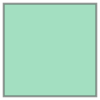

In [105]:
squares_gdf.geometry[0]

In [106]:
for index, row in squares_gdf.head(1).iterrows():
    print(f"Point {index + 1}: {row['geometry']}")

Point 1: POLYGON ((8.681497504504504 53.1532554954955, 8.681497504504504 53.162264504504506, 8.672488495495495 53.162264504504506, 8.672488495495495 53.1532554954955, 8.681497504504504 53.1532554954955))


## Get land use percentage 
(better version - old oversion is below in the notebook)

In [115]:
crs_projected = "EPSG:4326"
# crs_projected = "EPSG:3035"

squares_gdf_projected = squares_gdf.to_crs(crs_projected)
clc_projected = clc_4326.to_crs(crs_projected)

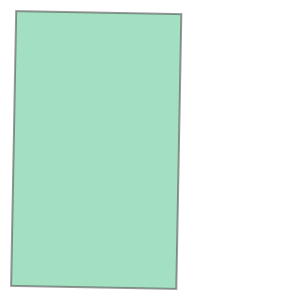

In [116]:
squares_gdf_projected.geometry[0]

In [117]:
for index, row in squares_gdf_projected.head(1).iterrows():
    print(f"Point {index + 1}: {row['geometry']}")

Point 1: POLYGON ((4232792.38673958 3339129.632365665, 4232810.766644299 3340132.022673403, 4232208.268462941 3340143.0029268507, 4232189.762982721 3339140.614569686, 4232792.38673958 3339129.632365665))


In [118]:
print(squares_gdf_projected.head(2).geometry)
print(clc_projected.head(2).geometry)

0    POLYGON ((4232792.387 3339129.632, 4232810.767...
1    POLYGON ((4251492.347 3335473.686, 4251506.816...
Name: geometry, dtype: geometry
0    MULTIPOLYGON (((3852601.053 2979540.102, 38526...
1    MULTIPOLYGON (((3851007.206 2981146.329, 38510...
Name: geometry, dtype: geometry


In [147]:
# EPGS:4326
joined = gpd.sjoin(squares_gdf_projected.head(100), clc_projected, how="inner", predicate='intersects')

def calc_intersection_area(row):
    return row['geometry'].intersection(clc_projected.at[row['index_right'], 'geometry']).area

joined['intersection_area'] = joined.apply(calc_intersection_area, axis=1)

grouped = joined.groupby([joined.index, 'Code_18'])['intersection_area'].sum()

total_area = squares_gdf_projected.geometry.area[0]

percentage_land_use = grouped / total_area

land_use_df = percentage_land_use.unstack(fill_value=0)

result = pd.concat([squares_gdf_projected, land_use_df], axis=1)
result.drop(columns=['geometry'], inplace=True)

In [140]:
# EPGS:3035
joined = gpd.sjoin(squares_gdf_projected.head(100), clc_projected, how="inner", predicate='intersects')

def calc_intersection_area(row):
    return row['geometry'].intersection(clc_projected.at[row['index_right'], 'geometry']).area

joined['intersection_area'] = joined.apply(calc_intersection_area, axis=1)

joined['total_area'] = joined.geometry.area

joined['percentage_land_use'] = joined['intersection_area'] / joined['total_area']

grouped = joined.groupby([joined.index, 'Code_18'])['percentage_land_use'].sum()

land_use_df = grouped.unstack(fill_value=0)

result = pd.concat([squares_gdf_projected, land_use_df], axis=1)
result.drop(columns=['geometry'], inplace=True)


In [146]:
result.head(10)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,111,112,121,124,131,132,141,142,211,221,222,231,311,312,313,321,322,324,331,411,412,421,423,511,512,521,522,sum
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,0.0,0.000000,0.000000,0.0,0.000000,0.0,5.384196e-08,0.110565,0.000000,0.0,0.0,0.384931,0.000000,0.0,0.000000,0.0,0.0,0.008314,0.0,0.0,0.0,0.0,0.0,0.000000,0.403113,0.0,0.093076,1.0
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,0.0,0.069894,0.514718,0.0,0.000000,0.0,0.000000e+00,0.000000,0.401880,0.0,0.0,0.013508,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
3,29666414,8,Haubentaucher,2018-01-01,51.076006,11.038316,157,8,NaN,de,50kmE4350N3100,0.0,0.000000,0.000000,0.0,0.006055,0.0,0.000000e+00,0.000000,0.139450,0.0,0.0,0.106843,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.747651,0.0,0.000000,1.0
4,29656211,8,Haubentaucher,2018-01-01,51.389380,7.067282,52,10,NaN,de,50kmE4100N3100,0.0,0.475355,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,0.012095,0.169137,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.343413,0.0,0.000000,1.0
5,29663609,384,Wasseramsel,2018-01-01,50.994558,7.498973,156,2,NaN,de,50kmE4100N3100,0.0,0.503782,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,0.126375,0.246003,0.0,0.123839,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0
6,29657892,8,Haubentaucher,2018-01-01,50.423980,7.510501,59,30,NaN,de,50kmE4100N3000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.293793,0.0,0.0,0.149321,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.013601,0.543285,0.0,0.000000,1.0
7,29657306,531,Rohrammer,2018-01-01,50.419474,7.505553,64,1,NaN,de,50kmE4100N3000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.452929,0.0,0.0,0.216424,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122174,0.208474,0.0,0.000000,1.0
8,29658782,8,Haubentaucher,2018-01-01,50.874160,6.844856,88,3,NaN,de,50kmE4050N3050,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.068953,0.0,0.0,0.000000,0.880936,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.050112,0.0,0.000000,1.0
9,29653391,338,Mittelspecht,2018-01-01,51.537290,7.444546,82,1,NaN,de,50kmE4100N3150,0.0,0.040296,0.329618,0.0,0.000000,0.0,6.300860e-01,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.0


In [148]:
result.head(10)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,111,112,121,124,131,132,141,142,211,221,222,231,311,312,313,321,322,324,331,411,412,421,423,511,512,521,522
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,0.0,0.000000,0.000000,0.0,0.000000,0.0,5.384196e-08,0.110565,0.000000,0.0,0.0,0.384931,0.000000,0.0,0.000000,0.0,0.0,0.008314,0.0,0.0,0.0,0.0,0.0,0.000000,0.403113,0.0,0.093076
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,1.000695,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,0.0,0.073554,0.541668,0.0,0.000000,0.0,0.000000e+00,0.000000,0.422921,0.0,0.0,0.014215,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,29666414,8,Haubentaucher,2018-01-01,51.076006,11.038316,157,8,NaN,de,50kmE4350N3100,0.0,0.000000,0.000000,0.0,0.006342,0.0,0.000000e+00,0.000000,0.146050,0.0,0.0,0.111900,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.783035,0.0,0.000000
4,29656211,8,Haubentaucher,2018-01-01,51.389380,7.067282,52,10,NaN,de,50kmE4100N3100,0.0,0.494508,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,0.012583,0.175952,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.357250,0.0,0.000000
5,29663609,384,Wasseramsel,2018-01-01,50.994558,7.498973,156,2,NaN,de,50kmE4100N3100,0.0,0.528543,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,0.132586,0.258094,0.0,0.129926,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
6,29657892,8,Haubentaucher,2018-01-01,50.423980,7.510501,59,30,NaN,de,50kmE4100N3000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.311966,0.0,0.0,0.158558,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.014442,0.576892,0.0,0.000000
7,29657306,531,Rohrammer,2018-01-01,50.419474,7.505553,64,1,NaN,de,50kmE4100N3000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.480991,0.0,0.0,0.229833,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.129743,0.221390,0.0,0.000000
8,29658782,8,Haubentaucher,2018-01-01,50.874160,6.844856,88,3,NaN,de,50kmE4050N3050,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.072527,0.0,0.0,0.000000,0.926604,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.052710,0.0,0.000000
9,29653391,338,Mittelspecht,2018-01-01,51.537290,7.444546,82,1,NaN,de,50kmE4100N3150,0.0,0.041785,0.341801,0.0,0.000000,0.0,6.533750e-01,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [144]:
cols = [111, 112, 121, 124, 131, 132, 141, 142, 211, 221, 222, 231, 311, 312, 313, 321, 322, 324, 331, 411, 412, 421, 423, 511, 512, 521, 522]

# Add the values of the columns together
result['sum'] = result[cols].sum(axis=1)

# Count the unique values of the sum
value_counts = result['sum'].value_counts(dropna=True)

# Print the value counts
print(value_counts)


sum
0.0    2659943
1.0         11
1.0          8
1.0          6
1.0          5
        ...   
1.0          1
1.0          1
1.0          1
1.0          1
1.0          1
Name: count, Length: 66, dtype: int64


In [145]:
print(result['sum'].round(10).unique())

[1. 0.]


In [134]:
nan_rows = result[result[112].isna()]
len(nan_rows)

0

In [300]:
nan_rows.head(5)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,111,112,121,124,131,132,141,142,211,221,222,231,311,312,313,321,322,324,331,411,412,421,423,511,512,521,522
100,29652137,8,Haubentaucher,2018-01-01,50.998337,11.050321,179,2,NaN,de,50kmE4350N3050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,29645081,8,Haubentaucher,2018-01-01,50.011574,8.082447,85,1,NaN,de,50kmE4150N2950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,29646267,8,Haubentaucher,2018-01-01,50.376511,8.850712,122,3,NaN,de,50kmE4200N3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,29661635,8,Haubentaucher,2018-01-01,50.376511,8.850712,122,5,NaN,de,50kmE4200N3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,29661866,469,Bergpieper,2018-01-01,50.376511,8.850712,122,1,NaN,de,50kmE4200N3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
category_dict = {
    111: 'urban_area_percent',
    112: 'urban_area_percent',
    121: 'urban_area_percent',
    122: 'urban_area_percent',
    123: 'urban_area_percent',
    124: 'urban_area_percent',
    131: 'industrial_area_percent',
    132: 'industrial_area_percent',
    133: 'industrial_area_percent',
    141: 'urban_area_percent',
    142: 'urban_area_percent',
    211: 'agriculture_area_percent',
    212: 'agriculture_area_percent',
    213: 'agriculture_area_percent',
    221: 'agriculture_area_percent',
    222: 'agriculture_area_percent',
    223: 'agriculture_area_percent',
    231: 'agriculture_area_percent',
    241: 'agriculture_area_percent',
    242: 'agriculture_area_percent',
    243: 'agriculture_area_percent',
    244: 'agriculture_area_percent',
    311: 'forest_area_percent',
    312: 'forest_area_percent',
    313: 'forest_area_percent',
    321: 'grassland_area_percent',
    322: 'grassland_area_percent',
    323: 'mediterranean_vegetation_area_percent',
    324: 'shrubland_area_percent',
    331: 'coastal_area_percent',
    332: 'rocky_area_percent',
    333: 'sparsley_vegetated_area_percent',
    334: 'burnt_area_percent',
    335: 'glacier_area_percent',
    411: 'wetlands_area_percent',
    412: 'wetlands_area_percent',
    421: 'wetlands_area_percent',
    422: 'wetlands_area_percent',
    423: 'wetlands_area_percent',
    511: 'water_area_percent',
    512: 'water_area_percent',
    521: 'water_area_percent',
    522: 'water_area_percent',
    523: 'water_area_percent',
    990: 'unclassified_land_area_percent',
    995: 'unclassified_water_area_percent',
    999: 'unclassified_area_percent'
}

category_df = result.copy()
for code, category in category_dict.items():
    if code in result.columns:
        if category not in category_df.columns:
            category_df[category] = result[code]
        else:
            category_df[category] += result[code]


columns_to_drop = [col for col in category_dict.keys() if col in category_df.columns]
category_df.drop(columns=columns_to_drop, inplace=True)


In [289]:
nan_rows = category_df[category_df['urban_area_percent'].isna()]
print(nan_rows.shape)
nan_rows.head(4)

(45, 27)


,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,land_use_coord,land_use_coord_numeric
155188,38355619,463,Wiesenpieper,2019-04-03,54.033346,6.626898,0,2,NaN,de,50kmE4100N3400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,unclassified,17
257889,34581793,463,Wiesenpieper,2018-09-04,54.494140,7.874070,0,0,NaN,de,50kmE4150N3450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,unclassified,17
257890,34581823,399,Steinschmätzer,2018-09-04,54.052516,6.640945,0,1,NaN,de,50kmE4100N3400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,unclassified,17
286363,31552365,531,Rohrammer,2018-04-05,55.087171,6.038972,-1,0,NaN,de,50kmE4050N3550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,unclassified,17


In [158]:
category_df.iloc[330499]

id_sighting                              42289691
id_species                                    463
name_species                         Wiesenpieper
date                                   2019-10-05
coord_lat                               51.208738
coord_lon                                8.826114
altitude                                      405
total_count                                    11
atlas_code                                    NaN
country                                        de
eea_grid_id                        50kmE4200N3100
urban_area_percent                            0.0
industrial_area_percent                       0.0
agriculture_area_percent                 2.044351
forest_area_percent                           0.0
grassland_area_percent                        0.0
shrubland_area_percent                        0.0
coastal_area_percent                          0.0
rocky_area_percent                            0.0
sparsley_vegetated_area_percent               0.0


In [159]:
cols_to_check = list(set(category_df.columns).intersection(set(category_dict.values())))

all_nan_rows = category_df[cols_to_check].isna().all(axis=1)

category_df.loc[all_nan_rows, cols_to_check] = 0

category_df.loc[all_nan_rows, 'unclassified_area_percent'] = 1

category_df.loc[~all_nan_rows, 'unclassified_area_percent'] = 0

In [160]:
category_df.iloc[330499]

id_sighting                              42289691
id_species                                    463
name_species                         Wiesenpieper
date                                   2019-10-05
coord_lat                               51.208738
coord_lon                                8.826114
altitude                                      405
total_count                                    11
atlas_code                                    NaN
country                                        de
eea_grid_id                        50kmE4200N3100
urban_area_percent                            0.0
industrial_area_percent                       0.0
agriculture_area_percent                 2.044351
forest_area_percent                           0.0
grassland_area_percent                        0.0
shrubland_area_percent                        0.0
coastal_area_percent                          0.0
rocky_area_percent                            0.0
sparsley_vegetated_area_percent               0.0


In [161]:
nan_rows3 = category_df[category_df['unclassified_area_percent'].isna()]
print(nan_rows3.shape)
nan_rows3.head(2)

(0, 27)


,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,land_use_coord,land_use_coord_numeric


In [162]:
category_df.head(3)

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,urban_area_percent,industrial_area_percent,agriculture_area_percent,forest_area_percent,grassland_area_percent,shrubland_area_percent,coastal_area_percent,rocky_area_percent,sparsley_vegetated_area_percent,burnt_area_percent,glacier_area_percent,wetlands_area_percent,water_area_percent,unclassified_area_percent,land_use_coord,land_use_coord_numeric
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,0.382590,0.0,0.799124,0.0,0.0,0.04353,0.0,0.0,0.0,0.0,0.0,0.0,0.774756,0.0,water,14
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,0.000000,0.0,2.000695,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,agriculture,3
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,0.832169,0.0,1.220190,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,urban,1


In [ ]:
# write
df_path = 'D:\Simon\Documents\GP\data\datasets\land_use\land_use_percentage.csv'
category_df.to_csv(df_path)

In [163]:
# write to other csvs
df_path = 'D:\Simon\Documents\GP\data\master_train2.csv'
category_df.to_csv(df_path)

## Get most common landuse within square

In [ ]:
# execution time: 132m
merged_squares = gpd.sjoin(squares_gdf, clc, how="left", predicate="intersects")

In [ ]:
merged_squares.head(1)

In [ ]:
merged_squares.reset_index(drop=True, inplace=True)

In [ ]:
common_land_use = merged_squares.groupby(merged_squares.index)['Code_18'].agg(lambda x: x.value_counts().idxmax() if not x.empty and not x.value_counts().empty else None)

common_land_use_df = pd.DataFrame({'Code_18_sq': common_land_use.values}, index=common_land_use.index)

In [ ]:
common_land_use_df.head(2)

In [ ]:
# write
df_path = 'D:\Simon\Documents\GP\data\datasets\land_use\land_use_most_common.csv'
common_land_use_df.to_csv(df_path)

## Get land use percentage 

In [ ]:
squares_with_clc = gpd.sjoin(clc, squares_gdf, how='inner', predicate='intersects')

# Calculate area of intersection between squares and CLC polygons for each Code_18 within each square
intersection_areas = squares_with_clc.groupby(['index_right', 'Code_18'])['geometry'].apply(lambda x: x.area)
total_areas = intersection_areas.groupby('index_right').sum()

# Calculate percentages of each Code_18 within each square
results = {}
for square_id, group in intersection_areas.groupby(level=0):
    percentages = {}
    for code_18, area in group.items():
        percentages[code_18[1]] = (area / total_areas[square_id])
    results[square_id] = percentages

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T.fillna(0)

In [ ]:
results_df.head(2)

In [ ]:
# Reset the index of results_df to make it easier to merge
results_df.reset_index(inplace=True)

# Merge the original DataFrame 'df' with results_df on the common index or a column
merged_df = pd.merge(df, results_df, left_index=True, right_on='index')

In [ ]:
merged_df.head(2)

In [ ]:
# write
df_path = 'D:\Simon\Documents\GP\data\datasets\land_use\land_use_percentage.csv'
merged_df.to_csv(df_path)

In [ ]:
common_land_use_df.head(3)

In [ ]:
# Merge the common land use DataFrame with the original DataFrame based on the index
merged_gdf = merged_squares.merge(common_land_use_df, left_index=True, right_index=True)
merged_gdf.drop(columns=['geometry'], axis=1, inplace=True)

In [ ]:
merged_gdf.head(3)

In [ ]:
clc_code_to_numerical_label = {
    111: 'urban', # 1
    112: 'urban',
    121: 'urban',
    122: 'urban',
    123: 'urban',
    124: 'urban',
    131: 'industrial', # 2
    132: 'industrial',
    133: 'industrial',
    141: 'urban', 
    142: 'urban',
    211: 'agriculture', # 3
    212: 'agriculture',
    213: 'agriculture',
    221: 'agriculture',
    222: 'agriculture',
    223: 'agriculture',
    231: 'agriculture',
    241: 'agriculture',
    242: 'agriculture',
    243: 'agriculture',
    244: 'agriculture',
    311: 'forest', # 4
    312: 'forest',
    313: 'forest',
    321: 'grassland', # 5 
    322: 'grassland',
    323: 'mediterranean_vegetation', # 6 
    324: 'shrubland', # 7 
    331: 'coastal', # 8 
    332: 'rocky_area',# 9
    333: 'sparsley_vegetated', # 10
    334: 'burnt_area', # 11
    335: 'glacier', # 12
    411: 'wetlands', # 13
    412: 'wetlands',
    421: 'wetlands',
    422: 'wetlands',
    423: 'wetlands',
    511: 'water', # 14
    512: 'water',
    521: 'water',
    522: 'water',
    523: 'water',
    990: 'unclassified_land', # 15
    995: 'unclassified_water', # 16
    999: 'unclassified' # 17
}
merged_gdf['land_use_coord'] = merged_gdf['Code_18'].map(clc_code_to_numerical_label)
merged_gdf['land_use_sq'] = merged_gdf['Code_18_sq'].map(clc_code_to_numerical_label)

In [ ]:
merged_gdf.head(3)

In [ ]:
merged_gdf['atlas_code'].fillna(0, inplace=True)

In [ ]:
merged_gdf.drop(columns=['Code_18', 'Code_18_sq'], axis=1, inplace=True)

In [ ]:
df_path = 'D:\Simon\Documents\GP\data\datasets\selected_species_50km_luse.csv'
merged_gdf.to_csv(df_path)